# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](/home/eugen/Coursera/OCR/readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [2]:
from zipfile import ZipFile

from PIL import Image
from PIL import ImageDraw
from kraken import pageseg
import pytesseract 
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
# the rest is up to you!

small_file = 'readonly/small_img.zip'
big_file = 'readonly/images.zip'

# A global list of dictionary objects PIL_Image, bounding boxes, text
gd = {}

#debug
#image = Image.open("readonly/text.png")
#text = pytesseract.image_to_string(image)
#print(text)
#image.close()

### Some useful functions

In [3]:
def zip_to_dict(zipfile):
    '''
    takes zip filename, makes OCR 
    
    :param: zipfile - zip filename
    
    :returns: a dictionary of list object, filename is a key
    '''

    zf = ZipFile(zipfile, mode='r')
    
    for el in zf.infolist():
        with zf.open(el) as file:
            img = Image.open(file)
            boxes = []
        
            # debug
            #print(img.size, img.mode, len(img.getdata()))
            #display(img)
            #print(file.name)
        
            # process OCR
            text = pytesseract.image_to_string(img).lower()
            #print(text[:16])

            # create a dictionary object      
            new_entry = {"image":img.copy(), "boxes":boxes, "text":text}
        
            gd[file.name] = new_entry
        
    zf.close()
                         
    return gd


def face_detect(pil_img):
    '''
    takes an image, finds the faces on it (if any), and returns a list of coordinate-tuples that bound the faces found
    
    :param: a PIL.Image object
    
    :returns: a list, containing 4-tuples
    '''
    boxes = []
    
    # convert img from PIL format into opencv
    cv2_image_gray = cv.cvtColor(np.array(pil_img), cv.COLOR_BGR2GRAY)
    
    try:
        faces = face_cascade.detectMultiScale(cv2_image_gray, scaleFactor =1.3, minNeighbors = 5).tolist()
    except Exception as ex:
        faces = []
    
    if (len(faces) > 0):
        for (x, y, w, h) in faces:
            boxes.append([x, y, x+w, y+h])
    
    return boxes


def contact_sheet(list_of_faces, sq_size=72):
    '''
    crafts a contact sheet
    '''
    
    #if type(list_of_PIL_images) != str: 
       # return 'contact sheet here :)'
    
    nrows = int(len(list_of_faces)/5) # set up for 5 (columns) per row
    contact_sht = Image.new(list_of_faces[0].mode, (sq_size*5, sq_size*(nrows+1)))
    
    (x,y) = (0,0)
    for img in list_of_faces:
        # paste in an image from the list
        img.thumbnail((sq_size,sq_size))
        contact_sht.paste(img, (x, y))
    
        # Update coordinates
        if x+sq_size == contact_sht.width:
            x = 0
            y = y+sq_size
        else:
            x = x+sq_size
      
    return contact_sht

Go through the zip archive

In [4]:

def search(zipfile=small_file, word='Christopher', mydict=None, return_cache=False):
    '''
    Makes binsearch the "word" in the zip archive "zipfile" of newspapers, prints all detected faces on the matched page
    
    :param: zipfile, search word, gd - global dictionary of previously processed data
    '''
    
    if (mydict == None):
        mydict = zip_to_dict(zipfile)
  
    for fn in mydict.keys():
        print(fn)
        if (word.lower() in mydict[fn]['text']):
            print("The word {} was found in {}".format(word, fn))
            
            boxes = mydict[fn]['boxes']
            # make face detection
            if ( len(boxes) == 0 ):
                boxes = face_detect(mydict[fn]['image'])
                mydict[fn]['boxes'] = boxes    
                
            # craft contact sheet
            if ( len(boxes) != 0 ):
                faces_list = []
                img = mydict[fn]['image']
                    
                # iterate through face coordinates
                for (x1,y1,x2,y2) in boxes:
                    face_img = img.crop((x1,y1,x2,y2))
                    faces_list.append(face_img)
            else:
                print("There are no detectable faces in {}".format(fn))
        
            # display contact_sheet
            display(contact_sheet(faces_list))
  
    if (return_cache == True):
        return mydict
    
    

a-0.png
The word Christopher was found in a-0.png


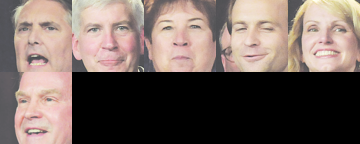

a-1.png
a-2.png
a-3.png
The word Christopher was found in a-3.png


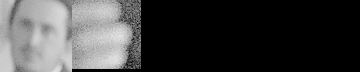

In [6]:
cache = search(word='Christopher', return_cache=True)

a-0.png
The word Mark was found in a-0.png


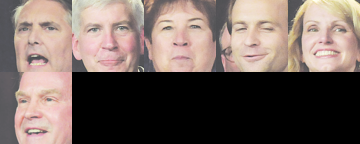

a-1.png
The word Mark was found in a-1.png


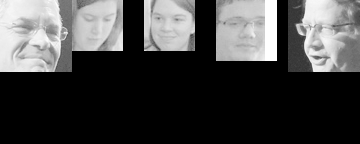

a-2.png
The word Mark was found in a-2.png


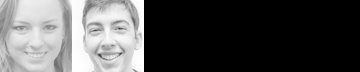

a-3.png
The word Mark was found in a-3.png


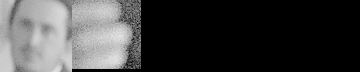

a-10.png
The word Mark was found in a-10.png
There are no detectable faces in a-10.png


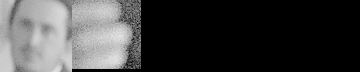

a-11.png
a-12.png
a-13.png
The word Mark was found in a-13.png


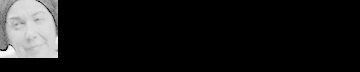

a-4.png
a-5.png
The word Mark was found in a-5.png


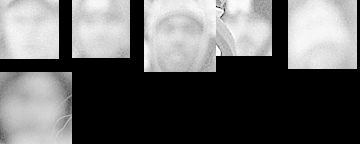

a-6.png
a-7.png
a-8.png
The word Mark was found in a-8.png
There are no detectable faces in a-8.png


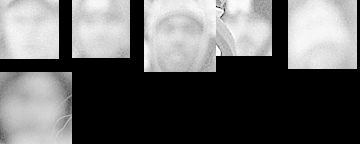

a-9.png
The word Mark was found in a-9.png


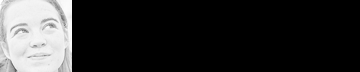

In [7]:
cache = search(zipfile = big_file, word='Mark', return_cache = True)